In [6]:

import numpy as np
 
suffix = "share-small-BiAtLSTM_0.1_75_30"

# Load the flattened results
preds = np.load( f"predictions_{suffix}.npy")           # Shape: [N]
trues = np.load(f"true_values_{suffix}.npy")           # Shape: [N, delay]
boundaries = np.load(f"window_boundaries_{suffix}.npy")    # Shape: [S, 2]
 
# Dictionary to hold separated sessions
session_data = {}
 
for i, (start, end) in enumerate(boundaries):
    # Slice the arrays using the boundaries
    session_data[f'session_{i}'] = {
        'predictions': preds[start:end],
        'ground_truth_sequences': trues[start:end],
        'num_windows': end - start
    }
 
# Example: Access the first session's predictions
print(session_data['session_4']['predictions'])


 
# ### 2. Should you change the logic to save session-wise?
# If your collaborator finds the slicing above confusing, or if you want the data to be more "self-documenting," you *could* change the saving logic. However, there are pros and cons:
 
# *   **Pros of Session-wise saving:** Easier to load a single session without loading the whole dataset; more intuitive structure.
# *   **Cons:** You end up with hundreds/thousands of small files (which is slow for OS file systems) or a very large, complex nested dictionary.
 
# ### 3. Recommendation: The "NPZ" Middle Ground
# Instead of saving many `.npy` files or one giant flat file, you can save everything into a single `.npz` file as a dictionary. This keeps the sessions separated but keeps the data in one file.
 
# If you want to modify your **experiment logic** to make this easier for your collaborator, you can change the saving block to this:
 

# Create a dictionary where keys are session IDs
session_dict = {}
for i, (start, end) in enumerate(boundaries):
    session_dict[f'session_{i}_preds'] = preds[start:end]
    session_dict[f'session_{i}_trues'] = trues[start:end]
    # session_dict[f'session_{i}_oracle'] = oracle_values[start:end]
 
# # Save everything into one compressed file
# np.savez_compressed('session_results.npz', **session_dict)
# ```
 
### Summary for your collaborator:
# If you stick with your **current** logic (which is fine and quite standard for high-performance training), just send them this explanation:

[0.12704366 0.0647481  0.04625209 0.02737569 0.02608976 0.02554956
 0.02356563 0.02501964 0.02609897 0.02437961 0.02550336 0.02440512]


Loading results for config: share-small-BiAtLSTM_0.1_75_30...
Successfully loaded 512 sessions.

--- Analysis of Session 0 ---
Number of windows in this session: 15
Mean Evaluation Cost for Session 0: 0.0918

--- Alignment check (Session 0, Window 5) ---
Model Prediction: 0.17
Oracle (Peak of future): 0.12
Valid future length: 30 steps
Raw sequence observed (first 5 steps): [nan nan nan nan nan]
Manual Oracle Verification: nan (Matches saved: False)


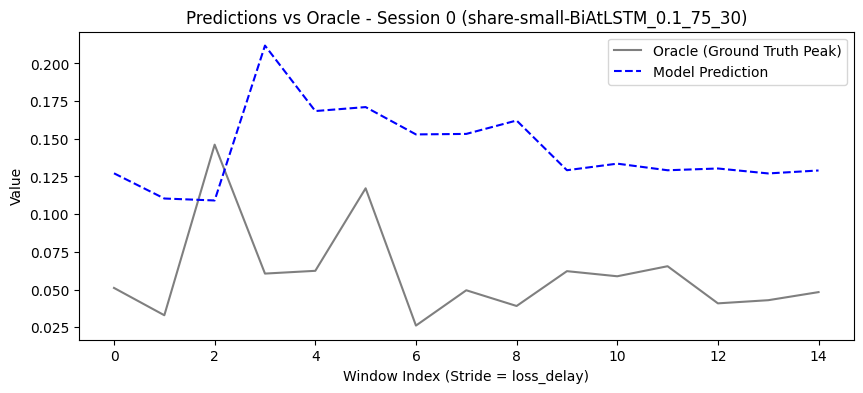

In [14]:
import numpy as np
import os
import matplotlib.pyplot as plt

def load_session_results(results_dir, config_suffix):
    """
    Loads all result files for a specific configuration and organizes them by session.
    """
    
    # Mapping the filenames based on your project's naming convention
    files = {
        'preds': f'predictions_{config_suffix}.npy',
        'preds_scaled': f'predictions_scaled_{config_suffix}.npy',
        'true': f'true_values_{config_suffix}.npy',
        'true_scaled': f'true_values_scaled_{config_suffix}.npy',
        'oracle': f'oracle_values_{config_suffix}.npy',
        'oracle_scaled': f'oracle_values_scaled_{config_suffix}.npy',
        'future_len': f'future_lengths_{config_suffix}.npy',
        'boundaries': f'window_boundaries_{config_suffix}.npy'
    }

    # Load raw flattened arrays
    data = {k: np.load(os.path.join(results_dir, v)) for k, v in files.items()}
    
    boundaries = data['boundaries']
    num_sessions = len(boundaries)
    
    sessions = []
    
    # Separate the flattened arrays into a list of session-specific dictionaries
    for i in range(num_sessions):
        start, end = boundaries[i]
        
        sess_dict = {
            'session_id': i,
            # Unscaled values (for business metrics/plotting)
            'preds': data['preds'][start:end],
            'true_sequences': data['true'][start:end],
            'oracle': data['oracle'][start:end],
            # Scaled values (for loss/gradient analysis)
            'preds_scaled': data['preds_scaled'][start:end],
            'true_sequences_scaled': data['true_scaled'][start:end],
            'oracle_scaled': data['oracle_scaled'][start:end],
            # Meta
            'future_lengths': data['future_len'][start:end]
        }
        sessions.append(sess_dict)
        
    return sessions

def calculate_evaluation_cost(preds, oracle, alpha=0.1, gamma=1.0):
    """
    Implements the custom cost metric used in the experiment:
    If Under-predicting (diff < 0): cost = alpha
    If Over-predicting (diff > 0):  cost = gamma * diff
    """
    diff = preds - oracle
    costs = np.where(diff < 0, alpha, gamma * diff)
    return costs

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    # 1. Setup paths and config
    # Update this to the folder containing your .npy files
    RESULTS_PATH = "./" 
    # Configuration: alpha=0.1, seq_len=82, loss_delay=30
    # CONFIG = "share-small-BiAtLSTM_0.1_82_30"
    CONFIG = "share-small-BiAtLSTM_0.1_75_30"
    
    # Parameters used during this specific training run
    RUN_ALPHA = 0.1
    RUN_GAMMA = 1.0 # Default gamma in your Experiment logic

    # 2. Load and Organize
    print(f"Loading results for config: {CONFIG}...")
    all_sessions = load_session_results(RESULTS_PATH, CONFIG)
    print(f"Successfully loaded {len(all_sessions)} sessions.")

    # 3. Demonstration: Analyze the first session
    first_sess = all_sessions[0]
    print(f"\n--- Analysis of Session 0 ---")
    print(f"Number of windows in this session: {len(first_sess['preds'])}")
    
    # Calculate costs for this session
    sess_costs = calculate_evaluation_cost(
        first_sess['preds'], 
        first_sess['oracle'], 
        alpha=RUN_ALPHA, 
        gamma=RUN_GAMMA
    )
    
    print(f"Mean Evaluation Cost for Session 0: {np.mean(sess_costs):.4f}")

    # 4. Demonstrate Data Alignment for a single window
    # Let's look at the 5th prediction window in the 1st session
    window_idx = 5
    p = first_sess['preds'][window_idx]
    o = first_sess['oracle'][window_idx]
    horizon = first_sess['future_lengths'][window_idx]
    raw_seq = first_sess['true_sequences'][window_idx] # This is [delay] long
    
    print(f"\n--- Alignment check (Session 0, Window {window_idx}) ---")
    print(f"Model Prediction: {p:.2f}")
    print(f"Oracle (Peak of future): {o:.2f}")
    print(f"Valid future length: {horizon} steps")
    print(f"Raw sequence observed (first 5 steps): {raw_seq[:5]}")
    
    # Verify that oracle is indeed the max of the valid horizon
    valid_part = raw_seq[:horizon]
    manual_oracle = np.max(valid_part)
    print(f"Manual Oracle Verification: {manual_oracle:.2f} (Matches saved: {np.isclose(o, manual_oracle)})")

    # 5. Quick Visualization Example
    plt.figure(figsize=(10, 4))
    plt.plot(first_sess['oracle'], label='Oracle (Ground Truth Peak)', color='black', alpha=0.5)
    plt.plot(first_sess['preds'], label='Model Prediction', color='blue', linestyle='--')
    plt.title(f"Predictions vs Oracle - Session 0 ({CONFIG})")
    plt.xlabel("Window Index (Stride = loss_delay)")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

In [18]:
import pandas as pd

In [ ]:
# 2. Load and Organize
print(f"Loading results for config: {CONFIG}...")
all_sessions = load_session_results(RESULTS_PATH, CONFIG)
print(f"Successfully loaded {len(all_sessions)} sessions.")

# 3. Demonstration: Analyze the first session
first_sess = all_sessions[0]
print(f"\n--- Analysis of Session 0 ---")
print(f"Number of windows in this session: {len(first_sess['preds'])}")

In [59]:
for i in range(511):
    first_sess = all_sessions[i]
    print(first_sess['true_sequences'])

[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]


In [57]:
all_sessions[511].keys()


dict_keys(['session_id', 'preds', 'true_sequences', 'oracle', 'preds_scaled', 'true_sequences_scaled', 'oracle_scaled', 'future_lengths'])

In [31]:
first_sess['session_id']

0

In [58]:
first_sess['true_sequences']

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan,

In [35]:
aaa= np.load('/home/sergi/5glena-lyapunov-mac-scheduler/Forecasting_results/notime/results/true_values_share-small-BiAtLSTM_0.1_75_30.npy')

In [36]:
aaa

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(6296, 30), dtype=float32)

In [22]:
first_sess['preds_scaled']

array([0.12704366, 0.11033101, 0.10903509, 0.211712  , 0.16830978,
       0.17094074, 0.15282209, 0.15315783, 0.16204515, 0.129082  ,
       0.13344133, 0.12905969, 0.13023162, 0.12695384, 0.12891346],
      dtype=float32)